# Ubaar's Competition
This is a regression problem.
We have to predict prices with respect to some features.
So let's go!

In [1]:
# import requirements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Data
First we should prepare our data for later processing.

In [2]:
# Load train dataset and take a look at it.
train_data = pd.read_csv('train.csv', index_col='ID')
train_data.head()

,date,sourceLatitude,sourceLongitude,SourceState,destinationLatitude,destinationLongitude,destinationState,distanceKM,taxiDurationMin,vehicleType,vehicleOption,weight,price
ID,,,,,,,,,,,,,
88142929797,960218,36.666045,48.489706,زنجان,29.600574,52.537114,فارس,1092.0,751.0,treili,kafi,20.00,15300000
30842979862,960511,32.323951,50.855412,چهارمحال و بختیاری,34.644923,50.876092,قم,414.0,264.0,khavar,mosaghaf_felezi,2.50,1800000
54262798716,960602,32.575448,51.581011,اصفهان,31.819508,49.865235,خوزستان,310.0,292.0,joft,kompressi,14.97,3742000
64071173752,960319,35.029685,48.085763,کردستان,35.703801,51.398824,تهران,391.0,271.0,khavar,mosaghaf_felezi,2.50,1300000
68088966447,960609,31.586965,54.449607,یزد,36.730367,53.965480,گلستان,756.0,573.0,joft,bari,15.00,8870000


In [3]:
# Get some info about data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 88142929797 to 70888028488
Data columns (total 13 columns):
date                    50000 non-null int64
sourceLatitude          50000 non-null float64
sourceLongitude         50000 non-null float64
SourceState             50000 non-null object
destinationLatitude     50000 non-null float64
destinationLongitude    50000 non-null float64
destinationState        50000 non-null object
distanceKM              49997 non-null float64
taxiDurationMin         49997 non-null float64
vehicleType             50000 non-null object
vehicleOption           50000 non-null object
weight                  50000 non-null float64
price                   50000 non-null int64
dtypes: float64(7), int64(2), object(4)
memory usage: 5.3+ MB


In [4]:
# Function for checking the missing values of DataFrame
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * mis_val / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Missing Values', 1: '% of Total Values'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
                                                              "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

# It seems we have just 3 rows containing missing values.
missing_values_table(train_data)

Your selected dataframe has 13 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
distanceKM,3,0.0
taxiDurationMin,3,0.0


In [3]:
# We can impute them by mean values without getting into stressful situations. they are just 3!
train_data.distanceKM.fillna(train_data.distanceKM.mean(), inplace=True)
train_data.taxiDurationMin.fillna(train_data.taxiDurationMin.mean(), inplace=True)

Now let's look at features. 
First of all, it seems that the *'int'* type isn't appropriate for **date** feature,
So we should extract some meaningfull features from **date**.
Let's do this by extracting *'year'*, *'month'* and *'day'* ...

In [4]:
# Extracting 'year', 'month' and 'day' from 'date' feature.
train_data['year'] = train_data.apply(lambda x: str(x['date'])[: 2], axis=1)
train_data['month'] = train_data.apply(lambda x: str(x['date'])[2: 4], axis=1)
train_data['day'] = train_data.apply(lambda x: str(x['date'])[4: ], axis=1)
train_data.drop('date', inplace=True, axis=1)

In [7]:
# Take a look ot these new features
train_data[['year', 'month', 'day']].describe()

,year,month,day
count,50000,50000,50000
unique,1,6,31
top,96,03,21
freq,50000,9286,1933




Feature 'year' has one unique value, we can filter out this DC feature ;)

Also I think that the day feature is not meaningfull in this concept, so I decided to extract Jalali Weekday and replace day by this new feature.

In [5]:
import jdatetime
def get_jweekday(row):
    date = jdatetime.date(year=int(row['year']), month=int(row['month']), day=int(row['day']))
    return str(date.weekday())

train_data['weekDay'] = train_data.apply(get_jweekday, axis=1)
train_data.weekDay.describe()

count     50000
unique        7
top           5
freq       8164
Name: weekDay, dtype: object

In [6]:
# Drop year and day
train_data.drop(['year', 'day'], inplace=True, axis=1)

# Exploratory Data Analysis
EDA time!
Good features is essential for a good predictor model. Some issues:

1- Feature-feature relationships (Collinear features, Nonlinear relationships between two features)

2- Feature-output relationships (Correlation or nonlinear relationships between each feature and output variable)

3- Outliers

## Feature-Feature relationships
We have some numeric features and many categorical features. For numeric features, it's good to know about distribution, regardless of other features and relationships between them. First we will take a look at linear relationships using **scatter plot** and **correlation analysis**.

In [7]:
# Extract numeric features
num_feats = train_data.select_dtypes(include='float').copy()
num_feats.head()

,sourceLatitude,sourceLongitude,destinationLatitude,destinationLongitude,distanceKM,taxiDurationMin,weight
ID,,,,,,,
88142929797,36.666045,48.489706,29.600574,52.537114,1092.0,751.0,20.00
30842979862,32.323951,50.855412,34.644923,50.876092,414.0,264.0,2.50
54262798716,32.575448,51.581011,31.819508,49.865235,310.0,292.0,14.97
64071173752,35.029685,48.085763,35.703801,51.398824,391.0,271.0,2.50
68088966447,31.586965,54.449607,36.730367,53.965480,756.0,573.0,15.00


In [ ]:
# PLot scatter matrix for numeric features
%matplotlib inline
pd.plotting.scatter_matrix(num_feats, figsize=(18, 16))

![title](Figure_1.png)

You can see that features **distanceKM** and **taxiDurationMin** are exactly the same. so we can drop one of these two features.

Now i will show you a funny thing, you can see my country's map in **sourceLatitude-sourceLongitude** section :D. Four features in dataset are Geo features, and they are locations of Source and Destination. If i simply calculate **Euclidean distance** and take it as a new feature, you can see a strong linear relationship between this new feature and **taxiDurationMin**.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AA63BFB390>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001AA6390B3C8>]], dtype=object)

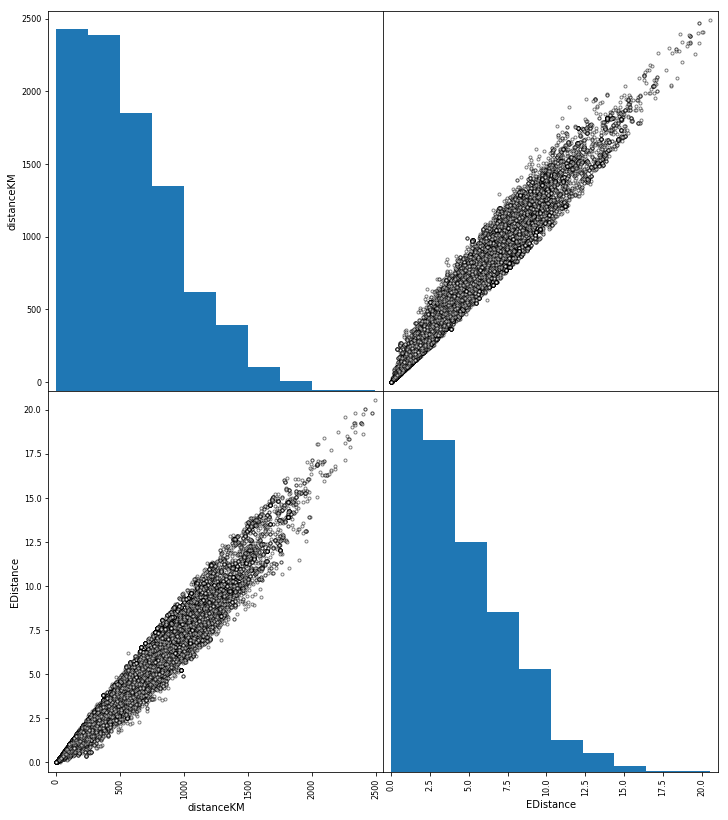

In [9]:
num_feats['EDistance'] = num_feats.apply(lambda x: np.sqrt(np.power(x['sourceLatitude'] - x['destinationLatitude'], 2)
                                                          +np.power(x['sourceLongitude'] - x['destinationLongitude'], 2)),
                                         axis=1)
%matplotlib inline
pd.plotting.scatter_matrix(num_feats[['distanceKM', 'EDistance']], figsize=(12, 14))

Then i can safely drop these features too.
But a smarter solution is dropping features that have less correlation with output variable **'price'**.

In [12]:
#Calculate correlations
pd.concat([num_feats, train_data['price']], axis=1).corr()

,sourceLatitude,sourceLongitude,destinationLatitude,destinationLongitude,distanceKM,taxiDurationMin,weight,EDistance,price
sourceLatitude,1.000000,-0.326393,0.341504,-0.086498,-0.155407,-0.155194,-0.045771,-0.097198,-0.193536
sourceLongitude,-0.326393,1.000000,-0.098981,0.421018,0.117507,0.101254,0.005589,0.119325,0.068531
destinationLatitude,0.341504,-0.098981,1.000000,-0.259354,-0.193994,-0.196477,-0.037710,-0.132470,-0.087720
destinationLongitude,-0.086498,0.421018,-0.259354,1.000000,0.204515,0.178945,0.020356,0.225779,0.084560
distanceKM,-0.155407,0.117507,-0.193994,0.204515,1.000000,0.992211,0.132903,0.976905,0.671204
taxiDurationMin,-0.155194,0.101254,-0.196477,0.178945,0.992211,1.000000,0.132462,0.959815,0.674452
weight,-0.045771,0.005589,-0.037710,0.020356,0.132903,0.132462,1.000000,0.130035,0.545604
EDistance,-0.097198,0.119325,-0.132470,0.225779,0.976905,0.959815,0.130035,1.000000,0.643038
price,-0.193536,0.068531,-0.087720,0.084560,0.671204,0.674452,0.545604,0.643038,1.000000


So i will keep the **taxiDurationMin** feature and drop other features, except **weight**.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AA646C4748>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001AA6471EA90>]], dtype=object)

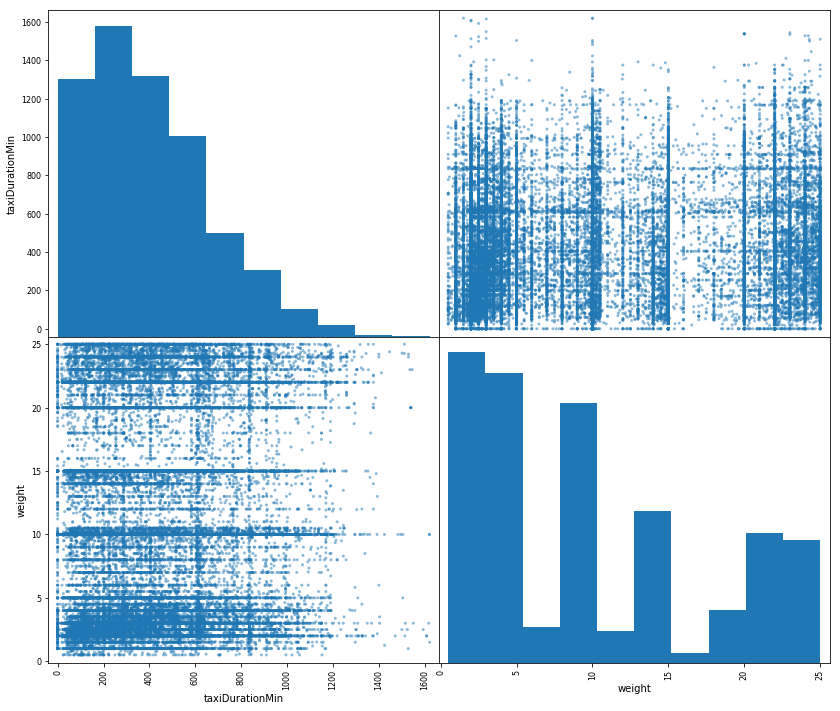

In [10]:
# Drop collinear features listed above
train_data.drop(['sourceLatitude', 'destinationLatitude', 'sourceLongitude', 'destinationLongitude', 'distanceKM'], inplace=True, axis=1)
num_feats.drop(['sourceLatitude', 'destinationLatitude', 'sourceLongitude', 'destinationLongitude', 'distanceKM', 'EDistance'], inplace=True, axis=1)
%matplotlib inline
pd.plotting.scatter_matrix(num_feats, figsize=(14, 12))

Now, it's *categorical* variables' turn. Correlation analysis between two categorical variables can be implemented through **chi-square test**. So I wrote a function that implements chi-square test on categorical variables and calculates p-values for null hypothesis that the two variables are independent, so if chi-square test for two given categorical variables is lower than 0.05, we can reject the null hypothesis and bravely conclude that these variables are dependent.

In [11]:
# Create a copy of categorical variables
cat_feats = train_data.select_dtypes(include='object').copy()

# Defining a function for implementing chi-square test on categorical features
from scipy import stats
def chi_square_test(df):
    
    # Function for implementing chi-square independence test on two series representing two cat features
    def get_chi2(column1, column2):
        
        # Create contingency table
        con_table = pd.crosstab(column1, column2)
        
        # Calculate chi2 test
        chi2, p, degree_f, expected = stats.chi2_contingency(con_table)
        return chi2, p, degree_f, expected
        
    # Extract categorical features
    cat_features = df.select_dtypes(include='object')
    
    # Implementing chi-squared test on cat features
    cols = cat_features.columns.tolist()
    table = list()
    for col1 in cols:
        l = list()
        for col2 in cols:
            chi2, p, degree_f, expected = get_chi2(df[col1], df[col2])
            if (expected < 5).any():    # If there is any <5 elemnt in expected array, test isn't trustable
                l.append(np.nan)
            else:
                l.append(p)
        table.append(l)
    return pd.DataFrame(table, columns=cols, index=cols)

chi_square_test(cat_feats)

,SourceState,destinationState,vehicleType,vehicleOption,month,weekDay
SourceState,NaN,NaN,0.000000e+00,NaN,4.552199e-139,3.172557e-70
destinationState,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,1.817483e-05
vehicleType,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,3.576135e-15,2.249200e-16
vehicleOption,NaN,0.000000,0.000000e+00,0.000000e+00,3.132392e-62,1.683544e-25
month,4.552199e-139,0.000000,3.576135e-15,3.132392e-62,0.000000e+00,1.186187e-178
weekDay,3.172557e-70,0.000018,2.249200e-16,1.683544e-25,1.186187e-178,0.000000e+00


In [12]:
# Drop month & weekDay because of having too much dependency with other features
chi_square_test(cat_feats.drop(['month', 'weekDay'], axis=1))

,SourceState,destinationState,vehicleType,vehicleOption
SourceState,NaN,NaN,0.0,NaN
destinationState,NaN,NaN,0.0,0.0
vehicleType,0.0,0.0,0.0,0.0
vehicleOption,NaN,0.0,0.0,0.0


We can drop three features **vehicleType** and **month** and **weekDay** without getting concerned. 

In [13]:
train_data.drop(['month', 'vehicleType', 'weekDay'], inplace=True, axis=1)
train_data.columns

Index(['SourceState', 'destinationState', 'taxiDurationMin', 'vehicleOption',
       'weight', 'price'],
      dtype='object')

## Feature-Output relationships

First append price to num_feats DataFrame:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AA647BA3C8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001AA66700EB8>]], dtype=object)

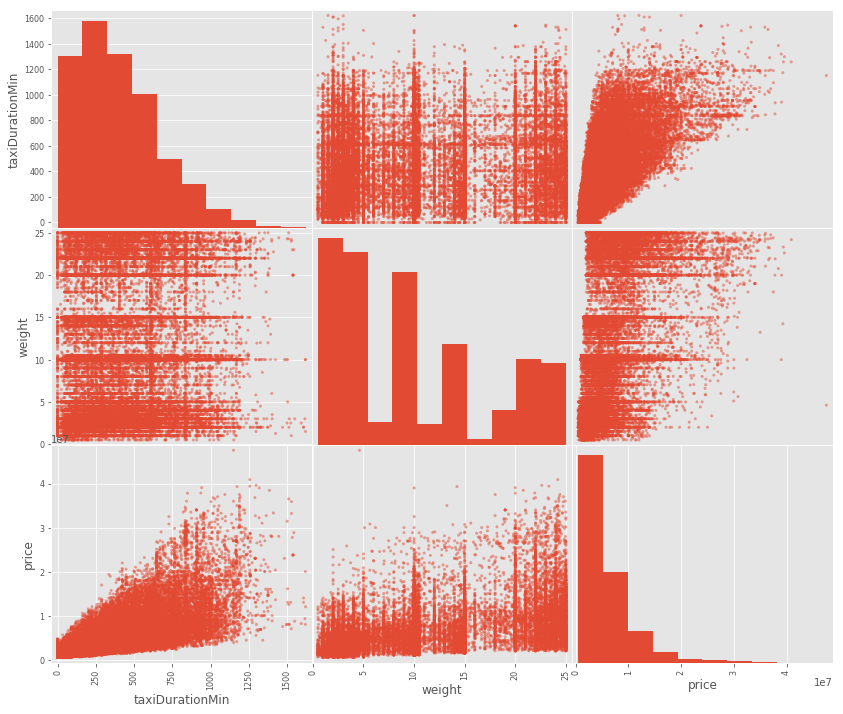

In [15]:
num_feats['price'] = train_data['price'].copy()
%matplotlib inline
plt.style.use('ggplot')
pd.plotting.scatter_matrix(num_feats, figsize=(14, 12))

We can see a spotlight :)) This is not too bad, but we can make this relationship more linear. Look at the distribution of **price** , **taxiDurationMin**. They are skewed, let's add log and sqrt transformed forms of **price** and **taxiDurationMin**:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AA667AE198>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001AA6AF77550>]], dtype=object)

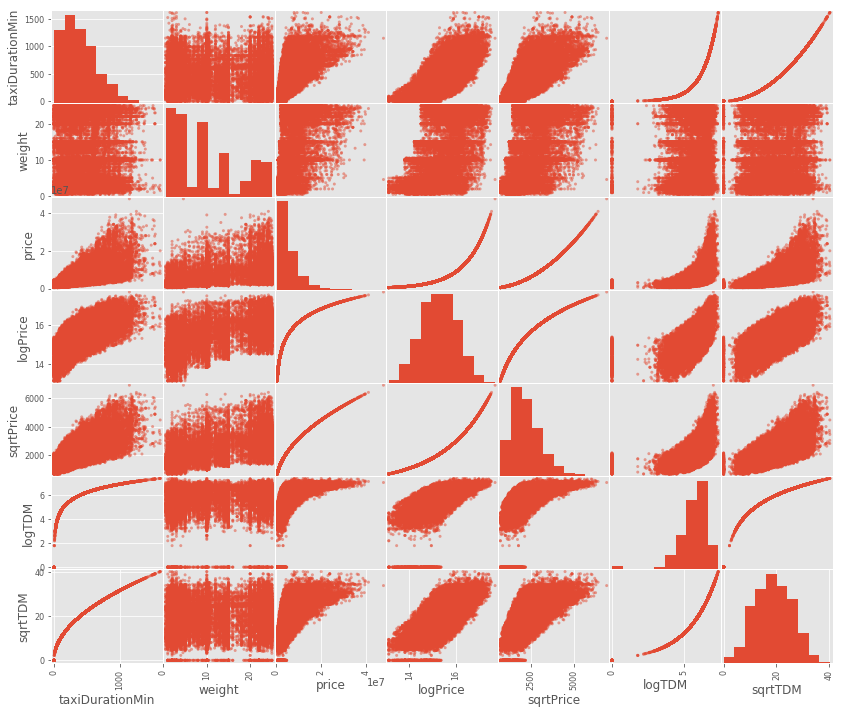

In [16]:
# Add new features
num_feats['logPrice'] = np.log(num_feats['price'])
num_feats['sqrtPrice'] = np.sqrt(num_feats['price'])
num_feats['logTDM'] = np.log1p(num_feats['taxiDurationMin'])
num_feats['sqrtTDM'] = np.sqrt(num_feats['taxiDurationMin'])
pd.plotting.scatter_matrix(num_feats, figsize=(14, 12))

We can see a near normal distribution for **logPrice** and **sqrtTDM** features, and the scatterplot for these features shows a better linear relationship. As you can see, we can take the weight feature as a categorical feature by a binning mechanism. so we will add **logPrice** and **sqrtTDM** to train_data, and make weight a categorical feature.

In [17]:
# Add two new near normal features
train_data['logPrice'] = np.log(train_data['price'])
train_data['sqrtTDM'] = np.sqrt(train_data['taxiDurationMin'])

# Add binnedWeight feature
def get_binned_weight(row):
    w = row['weight']
    if w < 5:
        return 'b1'
    elif w < 10:
        return 'b2'
    elif w < 15:
        return 'b3'
    else:
        return 'b4'
    
train_data['binnedWeight'] = train_data.apply(get_binned_weight, axis=1)
cat_feats['binnedWeight'] = train_data['binnedWeight'].copy()
train_data.columns

Index(['SourceState', 'destinationState', 'taxiDurationMin', 'vehicleOption',
       'weight', 'price', 'logPrice', 'sqrtTDM', 'binnedWeight'],
      dtype='object')

Now let's look for relationships between categorical features and output feature.

We can plot KDEs for every categorical feature and output feature. For every feature, group dataset by value of that feature, and plot the output variabale's distribution in every group. This way we can see the effect of categorical variables on output variable.

In [34]:
# Function for plotting the price distributions of grouped data by value of a feature
def plot_kde(df, groupby_var, output_var):
    %matplotlib inline
    tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
                 (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
                 (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
                 (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
                 (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
    c = [(i[0]/255., i[1]/255., i[2]/255.) for i in tableau20]
    g = df.groupby(groupby_var)
    for i, group in enumerate(g.groups.keys()):
        subset = g.get_group(group)[output_var]
        subset.plot.density(color=c[i])
    plt.legend(g.groups.keys())
    plt.title('KDE for {}, groupped by {}'.format(output_var, groupby_var))

def plot_box(df, by, column):
    %matplotlib inline
    tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
                 (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
                 (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
                 (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
                 (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
    c = [(i[0]/255., i[1]/255., i[2]/255.) for i in tableau20]
    df.boxplot(by=by, column=column, notch=True, vert=True, patch_artist=True, figsize=(16, 8), rot=90)

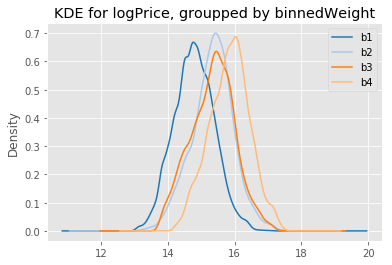

In [38]:
plot_kde(train_data, 'binnedWeight', 'logPrice')

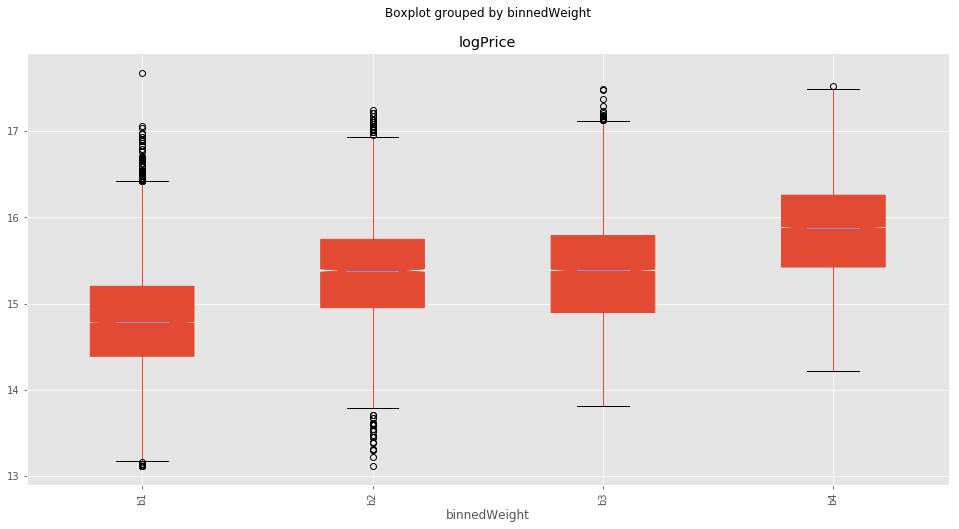

In [39]:
plot_box(train_data, 'binnedWeight', 'logPrice')

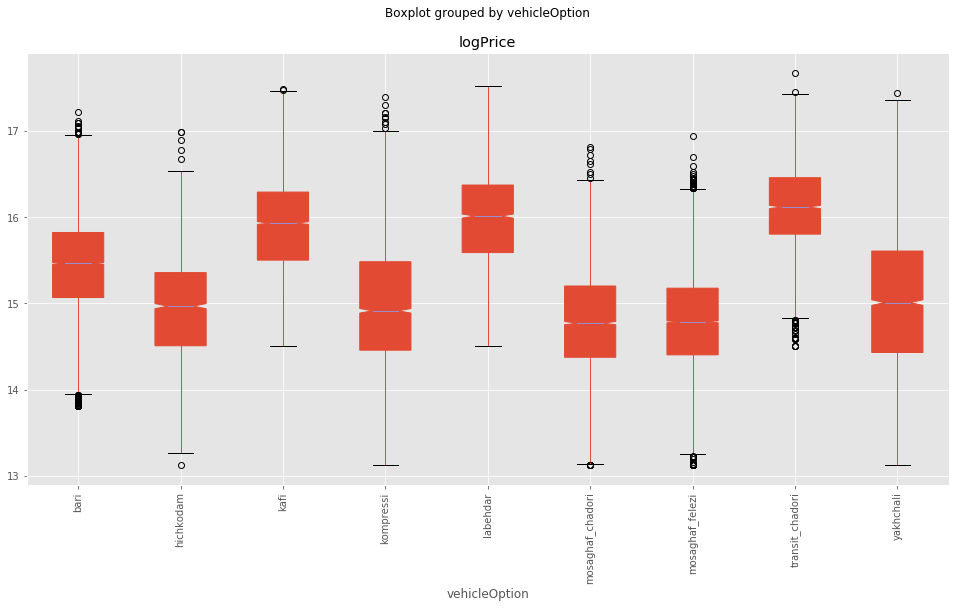

In [35]:
plot_box(train_data, 'vehicleOption', 'logPrice')

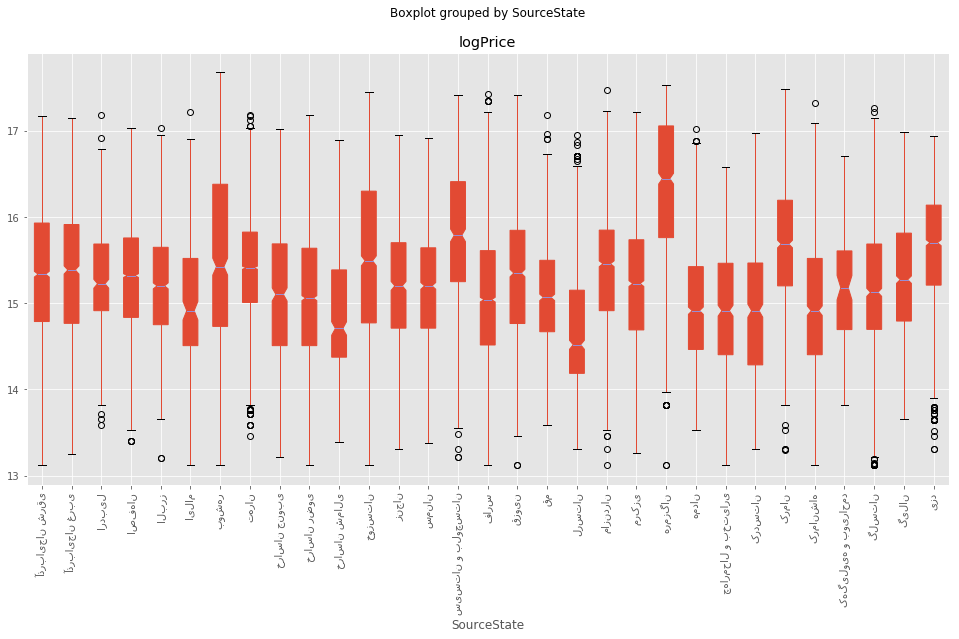

In [36]:
plot_box(train_data, 'SourceState', 'logPrice')

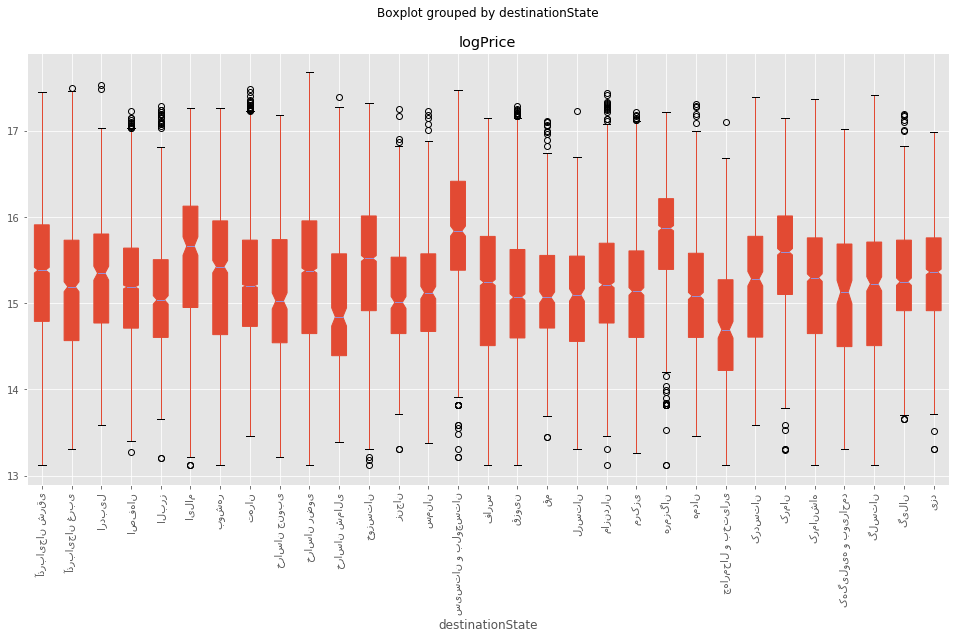

In [37]:
plot_box(train_data, 'destinationState', 'logPrice')

We can see that all categorical variables has a strong effect on output variable. However, for the case of **binnedWeight** variable, it makes sense if we merge b2 and b3.

In [40]:
# Merge b2 and b3
def change_bweights(row):
    w = row['binnedWeight']
    if w == 'b3':
        return 'b2'
    else:
        return w

train_data['binnedWeight'] = train_data.apply(change_bweights, axis=1)

And **mosaghaf_chadori** and **mosaghaf_felezi** in **vehicleOption** have the same situation: 

In [42]:
# Merge mosaghaf_chadori and mosaghaf_felezi
def change_vo(row):
    vo = row['vehicleOption']
    if vo == 'mosaghaf_felezi':
        return 'mosaghaf_chadori'
    else:
        return vo

train_data['vehicleOption'] = train_data.apply(change_vo, axis=1)

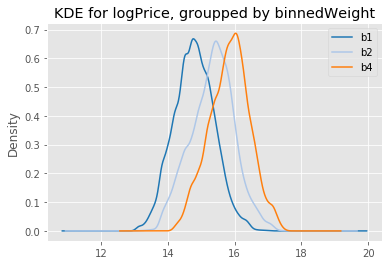

In [41]:
plot_kde(train_data, 'binnedWeight', 'logPrice')

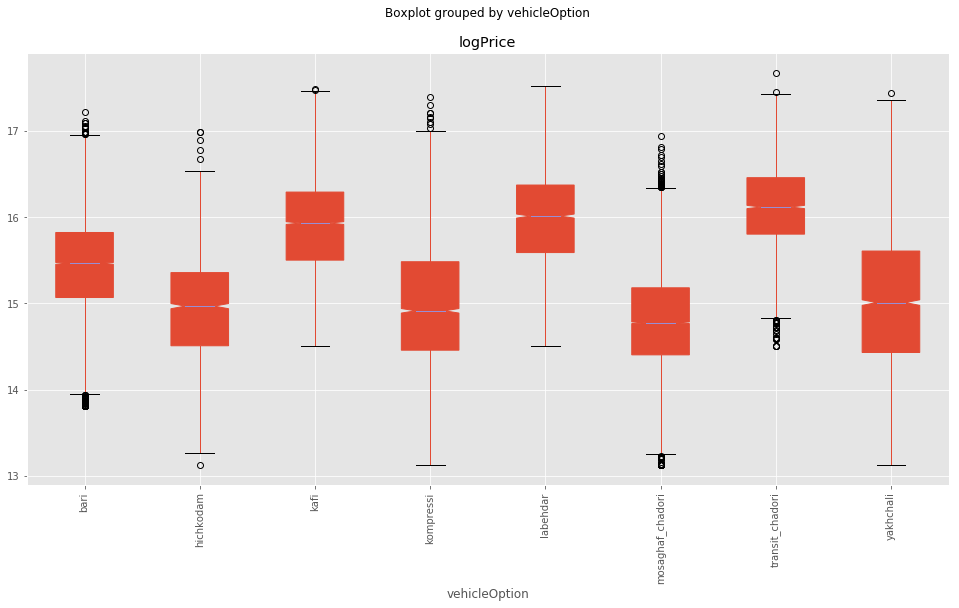

In [43]:
plot_box(train_data, 'vehicleOption', 'logPrice')

## Outliers

For outlier detection, I will use IQR measure, so every data point that lies inside (Q1 - 2IQR, Q3 + 2IQR), will known as inlier and other point are outliers.

In [44]:
# Identify outliers
q1 = train_data['logPrice'].quantile(0.25)
q3 = train_data['logPrice'].quantile(0.75)
iqr = q3 - q1
mask = train_data['logPrice'].between(q1 - 1.5*iqr, q3 + 1.5*iqr)
outliers = train_data.loc[~mask, 'logPrice']

In [45]:
outliers.describe()

count    10.000000
mean     17.499543
std       0.066541
min      17.447820
25%      17.468420
50%      17.483672
75%      17.492998
max      17.677292
Name: logPrice, dtype: float64

We have 10 outliers, and we can drop them.

In [46]:
# Drop outliers
train_data.drop(outliers.index.values, inplace=True)

In [47]:
# Add two new features: sameState and zeroDistance
train_data['sameState'] = train_data.apply(lambda x: x['SourceState'] == x['destinationState'], axis=1)
train_data['zeroDistance'] = train_data.apply(lambda x: x['sqrtTDM'] == 0, axis=1)

Now, by creating dummy variables out of categorical variables, preprocessing step will be over, and we have a dataset that is cleaned and ready for fitting a regression model.

In [48]:
# Make dummy variabels (one-hot encoding)
data = pd.get_dummies(train_data.drop(['taxiDurationMin', 'weight', 'price'], axis=1))
data.shape

(49990, 77)

Before stepping into model selection, let's save our cleaned data somewhere.

In [50]:
data.to_csv('ubaar_data.csv', encoding='UTF-8')